# Object detection

Using the MNIST dataset, we will place numbers on different parts of a canvas. Then our model will put a bounding box around the numbers and also detect what number is inside. I would also like for the model to be able to identiy multiple numbers in the same picture if they are visible while also ignoring noise, like lines or symbols.

## 1. Dataset
The MNIST dataset has all the numbers in the center of the screen, we will need to make these images.

1. Using a black canvas we will place between 1 and 5 MNIST digits on the canvas on random locations
2. The digits will vary in size and the images will be rotated up to 10 degrees for variance
3. We will track the location of the bounding box
4. Save: image + labels (digit_class, x, y, width, height)

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image, ImageDraw
import random
import math

In [51]:
def load_mnist_data():
    transform = transforms.Compose([transforms.ToTensor()])

    train_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )

    test_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=False,
        download=True,
        transform=transform
    )

    return train_dataset, test_dataset

In [52]:
class DigitPlacer:
    def __init__(self, canvas_size=224, min_digit_size=20, max_digit_size=40, max_rotation=10):
        self.canvas_size = canvas_size
        self.min_digit_size = min_digit_size
        self.max_digit_size = max_digit_size
        self.max_rotation = max_rotation

    def process_single_digit(self, mnist_image, target_size=None, rotation_angle=None):
        mnist_array = mnist_image.squeeze().numpy() # Tensor to image
        mnist_array = (mnist_array * 255).astype(np.uint8) 

        digit_pil = Image.fromarray(mnist_array, mode='L')

        if target_size is None:
            target_size = random.randint(self.min_digit_size, self.max_digit_size)

        if rotation_angle is None:
            rotation_angle = random.uniform(-self.max_rotation, self.max_rotation)

        digit_resized = digit_pil.resize((target_size, target_size), Image.Resampling.LANCZOS)
        digit_rotated = digit_resized.rotate(rotation_angle, expand=True, fillcolor=0)

        return digit_rotated, target_size, rotation_angle
                
    def place_digit_on_canvas(self, canvas, digit_image, position=None):
        digit_width, digit_height = digit_image.size
        canvas_width, canvas_height = canvas.size

        if position is None:
            max_X = canvas_width - digit_width
            max_Y = canvas_height - digit_height

            x = random.randint(0, max_X)
            y = random.randint(0, max_Y)
        else:
            x, y = position

        new_canvas = Image.new('L', (self.canvas_size, self.canvas_size), color=(0))
        new_canvas.paste(digit_image, (x,y))

        # Since black is 0 and white is 255 we can add the arrays of two images to just transfer the white - in this case the stroke of the digit
        canvas_array = np.array(canvas, dtype=np.float32)
        new_canvas_array = np.array(new_canvas, dtype=np.float32)

        canvas_array = np.minimum(canvas_array + new_canvas_array, 255)
        updated_canvas = Image.fromarray(canvas_array.astype(np.uint8))

        return updated_canvas, (x, y, digit_width, digit_height)


In [53]:
canvas = Image.new('L', (224, 224), color=(0))
placer = DigitPlacer(224)
annotations = [] # Empty array for annotations

train_dataset, test_dataset = load_mnist_data()

for i in range(5):
    idx = random.randint(0, len(train_dataset) - 1)
    mnist_image, digit_class = train_dataset[idx]

    processed_digit, size, rotation = placer.process_single_digit(mnist_image)
    canvas, bbox = placer.place_digit_on_canvas(canvas, processed_digit)

    if bbox is not None:
        #x, y, width, height = bbox
        annotations.append({
            'class':digit_class,
            'bbox': bbox,
            'size': size,
            'rotation': rotation
        })

C:\Users\filip\AppData\Local\Temp\ipykernel_13368\2370921591.py:12: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  digit_pil = Image.fromarray(mnist_array, mode='L')


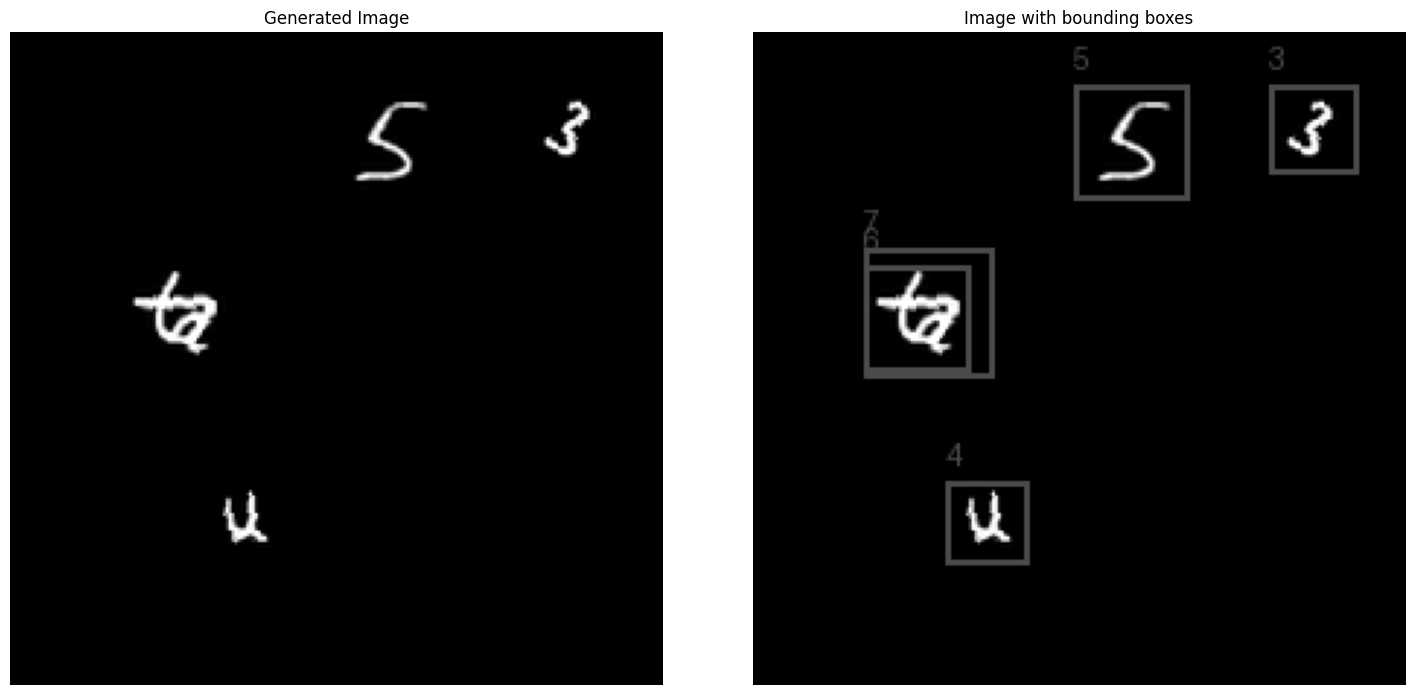

In [54]:
canvas_with_bbox = canvas.copy()
draw = ImageDraw.Draw(canvas_with_bbox)

for i, ann in enumerate(annotations):
    digit_class = ann['class']
    x, y, width, height = ann['bbox']

    # Draw rectangle
    draw.rectangle([x, y, x+width, y+height], outline='green', width=2)
    label = f'{digit_class}'
    draw.text((x, y-15), label, fill='green')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Original image
ax1.imshow(canvas, cmap='gray')
ax1.set_title("Generated Image")
ax1.axis('off')

# Image with boudning box
ax2.imshow(canvas_with_bbox, cmap='gray')
ax2.set_title("Image with bounding boxes")
ax2.axis('off')

plt.tight_layout()
plt.show()

Now that the algorithm for data synthesis works, we can work on creating a dataset alongside labels for the model to train on

We are going to split the data as 5:1:1 between train, validate and test
Hence, for a 1000 training dataset, we will need 200 val and 200 test

In [55]:
def generate_image(mnist_dataset, placer, min_digits=1, max_digits=5):
    num_digits = np.random.randint(min_digits, max_digits + 1)
    canvas = Image.new('L', (224, 224), color=(0))
    annotations = []
    for i in range(num_digits):
        idx = random.randint(0, len(mnist_dataset) - 1)
        mnist_image, digit_class = mnist_dataset[idx]

        processed_digit, size, rotation = placer.process_single_digit(mnist_image)
        canvas, bbox = placer.place_digit_on_canvas(canvas, processed_digit)

        if bbox is not None:
            annotations.append({
                'class':digit_class,
                'bbox': bbox,
                'size': size,
                'rotation': rotation
            })

    return canvas, annotations

1
[{'class': 0, 'bbox': (103, 179, 30, 30), 'size': 28, 'rotation': -3.7194389497795433}]


C:\Users\filip\AppData\Local\Temp\ipykernel_3032\2370921591.py:12: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  digit_pil = Image.fromarray(mnist_array, mode='L')


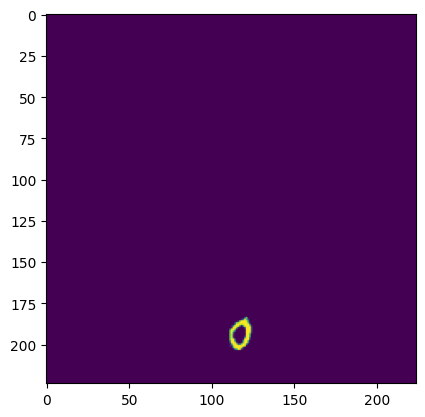

In [82]:
# test
canvas, a = generate_image(train_dataset, placer)

print(a)

plt.imshow(canvas)

In [56]:
# Normalise labels
def normalise_annotations(annotations, canvas):
    img_width, img_height = canvas.size
    norm_annotations = []

    for a in annotations:
        x, y, w, h = a['bbox']

        # Convert to center coordinates
        x_center = x + w/2
        y_center = y + h/2

        # Normalise bbox to image dimensions
        x_center_norm = x_center / img_width    
        y_center_norm = y_center / img_height
        width_norm = w / img_width
        height_norm = h / img_height

        # Clamp values between 0 and 1 - should already be close...
        x_center_norm = max(0, min(1, x_center_norm))
        y_center_norm = max(0, min(1, y_center_norm))
        width_norm = max(0, min(1, width_norm))
        height_norm = max(0, min(1, height_norm))

        norm_annotations.append({
            'class':a['class'],
            'bbox': (x_center_norm, y_center_norm, width_norm, height_norm),
            'size': a['size'],
            'rotation': a['rotation']
            })

    return norm_annotations

In [87]:
print(normalise_annotations(a, canvas))

{'class': 0, 'bbox': (103, 179, 30, 30), 'size': 28, 'rotation': -3.7194389497795433}
(103, 179, 30, 30)
[{'class': 0, 'bbox': (0.5267857142857143, 0.8660714285714286, 0.13392857142857142, 0.13392857142857142), 'size': 28, 'rotation': -3.7194389497795433}]


In [57]:
import os

def store_image(image, annotations, split_name):
    img_filename = f"{split_name}_{i:06d}.jpg"
    img_path = os.path.join('./data/mnist_detection_dataset/images', split_name, img_filename)

    if image.mode != "RGB":
        image = image.convert('RGB')

    image.save(img_path, 'JPEG', quality=95)

    label_filename = f"{split_name}_{i:06d}.txt"
    label_path = os.path.join('./data/mnist_detection_dataset/labels', split_name, label_filename)

    with open(label_path, 'w') as f:
        for ann in annotations:
            class_id = ann['class']
            bbox = ann['bbox']

            f.write(f"{class_id} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")

In [ ]:
# Generate and store images in appropriate files

train = 1000
val = int(train * (1/5))
test = val

for i in range(train):
    image, annotations = generate_image(train_dataset, placer)
    annotations = normalise_annotations(annotations, image)
    store_image(image, annotations, "train")

for i in range(val):
    image, annotations = generate_image(train_dataset, placer)
    annotations = normalise_annotations(annotations, image)
    store_image(image, annotations, "val")

for i in range(val):
    image, annotations = generate_image(test_dataset, placer)
    annotations = normalise_annotations(annotations, image)
    store_image(image, annotations, "test")


C:\Users\filip\AppData\Local\Temp\ipykernel_13368\2370921591.py:12: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  digit_pil = Image.fromarray(mnist_array, mode='L')


## 1.2 Loading the data

After we created the data, we also need to consider how to data is going to be loaded. Since we are using PyTorch, we will need to use a PyTorch Tensor.

In [17]:
import os
import torch
from PIL import Image
import torchvision.transforms as transforms

In [18]:
def load_data(data_dir, split='train', img_size=224):
    images_dir = os.path.join(data_dir, 'images', split)
    label_dir = os.path.join(data_dir, 'labels', split)

    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()
    ])

    images = []
    annotations = []

    image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
    image_files.sort()

    for img_name in image_files:
        img_path = os.path.join(images_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        image = transform(image)

        label_name = img_name.replace('.jpg', '.txt')
        label_path = os.path.join(label_dir, label_name)

        boxes = []
        labels = []

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        class_id = int(parts[0])
                        x_center = float(parts[1])
                        y_center = float(parts[2])
                        width = float(parts[3])
                        height = float(parts[4])

                        labels.append(class_id)
                        boxes.append([x_center, y_center, width, height])

        images.append(image)
        annotations.append({
            'boxes': torch.tensor(boxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.long)
        })
    
    return images, annotations

In [19]:
""" The DataLoader expects the data collated """
def collate_fn(batch):
    images, targets = zip(*batch)
    return torch.stack(images), list(targets)

In [20]:
""" Loading the data and validating it """

from torch.utils.data import DataLoader

BATCH_SIZE = 16

# Loading the data into memory
train_images, train_labels  = load_data('./data/mnist_detection_dataset', split='train')
val_images, val_labels  = load_data('./data/mnist_detection_dataset', split='val')
test_images, test_labels = load_data('./data/mnist_detection_dataset', split='test')

train_dataset = list(zip(train_images, train_labels))
val_dataset = list(zip(test_images, train_labels))
test_dataset = list(zip(test_images, test_labels))

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

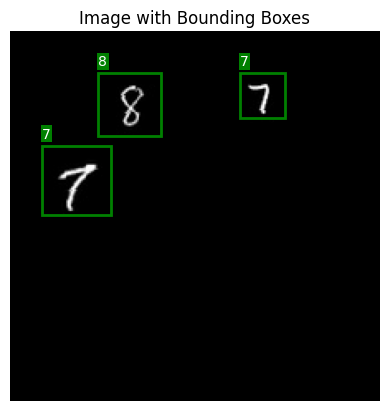

In [63]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Get a batch
images, labels = next(iter(test_loader))

# Select the first image and its annotations
image = images[0].permute(1, 2, 0).numpy()  # [C, H, W] → [H, W, C]
target = labels[0]
boxes = target['boxes']
classes = target['labels']

# Image dimensions (needed to denormalize boxes)
img_h, img_w, _ = image.shape

# Create a plot
fig, ax = plt.subplots(1)
ax.imshow(image)
ax.set_title("Image with Bounding Boxes")

# Draw each bounding box
for box, cls in zip(boxes, classes):
    # YOLO format: [x_center, y_center, width, height] in [0,1]
    x_c, y_c, w, h = box

    # Convert to pixel coordinates
    x_c *= img_w
    y_c *= img_h
    w *= img_w
    h *= img_h

    # Convert center-based box to top-left corner format for matplotlib
    x_min = x_c - w / 2
    y_min = y_c - h / 2

    # Create a rectangle patch
    rect = patches.Rectangle((x_min, y_min), w, h, linewidth=2, edgecolor='green', facecolor='none')

    # Add the rectangle to the plot
    ax.add_patch(rect)

    # Optionally add class label
    ax.text(x_min, y_min - 5, str(cls.item()), color='white', fontsize=10,
            bbox=dict(facecolor='green', edgecolor='none', pad=1))

plt.axis('off')
plt.show()


## 2. Object Detection architecture
In classification the model takes one image and makes a prediction.
In detection we also have to figure out where something is. We will need to first perform feature extraction, then detect and see if we can identify something. 

The backbone of Feature Extraction is CNN - Convolutional Neural Network which basically means that a Convolutional layer - or layers - perform feature extraction on the input.

What should be understood is that Detection is a regression task. Reading the YOLO paper in more detail, we understand that the architecture consists of a CNN which is trained for feature extraction. After it is trained then we create add two fully connected layers to it which help detect.

## 3. Convolutional Neural Networks
CNNs are deep learning models which specialise on grid-like data, commonly images. They are able to identify patterns and objects through the process of convolution - same processed used in edge detection. CNNs are good feature extractors. 
They consist of:
- **Convolutional layers:** These layers apply filters which act as feature detectors. The specialise on the detection of patterns, edge, curves and even textures. Due to parameter sharing through the layer, the same filter can be applied anywhere. 
- **Pooling layers:** A pooling layer - often Max Pooling or Average Pooling - is used to reduce the spacial dimensions of the feature map. This reduces computational intensity and helps make the network more resilient to variation in the inputs.

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [79]:
def create_cnn_classifier():
    model = nn.Sequential(
        # This is alot smaller than the YOLO CNN but we are only trying to identify numbers in a black bg
        nn.Conv2d(1, 32, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),

        #Classification head
        nn.AdaptiveAvgPool2d((1,1)),
        nn.Flatten(),
        nn.Linear(128, 64),
        nn.ReLU(inplace=True),
        nn.Linear(64, 10) # 10 MNIST classes
    )

    return model

In [7]:
def load_mnist_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,),(0.3081,))
    ])

    train_dataset = torchvision.datasets.MNIST(
        root='data', train=True, download=False, transform=transform
    )

    test_dataset = torchvision.datasets.MNIST(
        root='data', train=False, download=False, transform=transform
    )

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    return train_loader, test_loader

In [96]:
def train_classification(model, train_loader, test_loader, epochs=10, device='cpu'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimiser = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        print("="*25)
        print(f"Epoch {epoch+1}")

        model.train() # Put model in training mode
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimiser.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimiser.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

            if batch_idx % 100 ==0:
                print(f"    Batch {batch_idx}, Loss: {loss.item():.4f}")

        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                test_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                test_total += target.size(0)
                test_correct += (predicted == target).sum().item()

        train_acc = 100 * train_correct / train_total
        test_acc = 100 * test_correct / test_total

        print(f"    Train accuracy: {train_acc:.2f}%")
        print(f"    Test accuracy: {test_acc:.2f}")

    return model

In [97]:
train_loader, test_loader = load_mnist_data()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = create_cnn_classifier()

trained_model = train_classification(model, train_loader, test_loader, epochs=5, device=device)

Epoch 1
    Batch 0, Loss: 2.3039
    Batch 100, Loss: 1.7447
    Batch 200, Loss: 0.9204
    Batch 300, Loss: 0.3730
    Batch 400, Loss: 0.2458
    Batch 500, Loss: 0.2022
    Batch 600, Loss: 0.4185
    Batch 700, Loss: 0.2596
    Batch 800, Loss: 0.0828
    Batch 900, Loss: 0.0666
    Train accuracy: 82.25%
    Test accuracy: 97.39
Epoch 2
    Batch 0, Loss: 0.1306
    Batch 100, Loss: 0.3193
    Batch 200, Loss: 0.0655
    Batch 300, Loss: 0.1452
    Batch 400, Loss: 0.0278
    Batch 500, Loss: 0.0587
    Batch 600, Loss: 0.0149
    Batch 700, Loss: 0.0407
    Batch 800, Loss: 0.1712
    Batch 900, Loss: 0.0636
    Train accuracy: 97.63%
    Test accuracy: 98.48
Epoch 3
    Batch 0, Loss: 0.0496
    Batch 100, Loss: 0.1025
    Batch 200, Loss: 0.0581
    Batch 300, Loss: 0.0105
    Batch 400, Loss: 0.1858
    Batch 500, Loss: 0.0283
    Batch 600, Loss: 0.0179
    Batch 700, Loss: 0.0033
    Batch 800, Loss: 0.0025
    Batch 900, Loss: 0.0283
    Train accuracy: 98.47%
    Test ac

In [93]:
def predict(model, image, device):
    model.eval()
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        raw_outputs = model(image)
        _, predicted = torch.max(raw_outputs.data, 1)

    return predicted.item()        

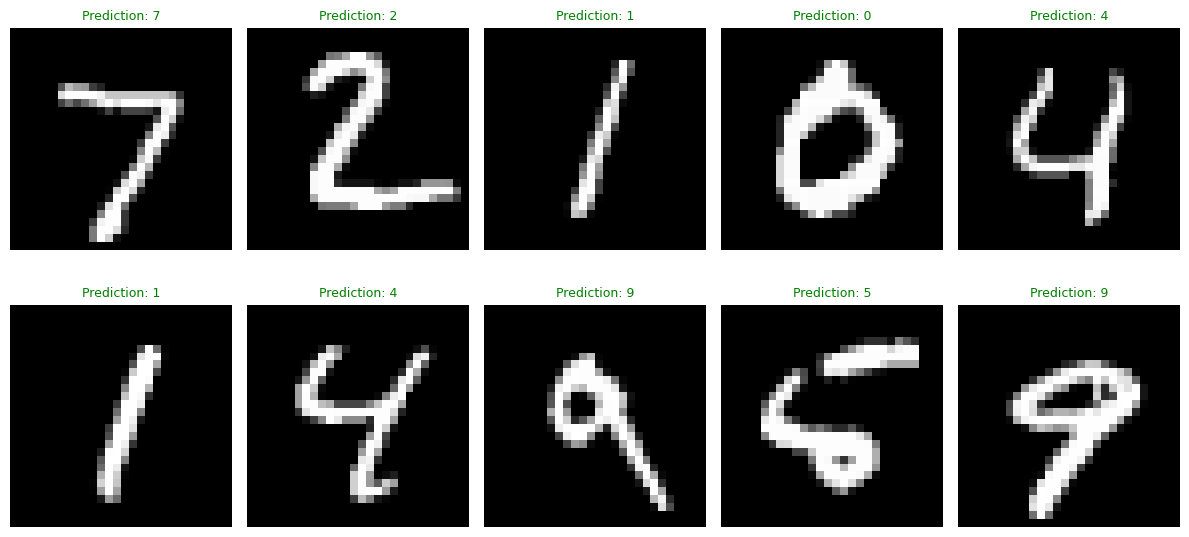

In [98]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
device = torch.device('cpu')

test_iter = iter(test_loader)

images, labels = next(test_iter)
images, labels = images.to(device), labels.to(device)

for i in range(10):
    image = images[i]
    label = labels[i].item()

    prediction = predict(trained_model, image, device)

    row = i // 5
    col = i % 5

    axes[row, col].imshow(image.cpu().squeeze().numpy(), cmap='gray')
    if prediction == label:
        title_color = 'green'
    else:
        title_color = 'red'

    title = f"Prediction: {prediction}"
    axes[row, col].set_title(title, color=title_color, fontsize=9)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

Now that the network is trained we need to cut off the layers that we need - everthing but the last 3 layers which are responsible for the classification task. Then we need to save the model weights. 

In theory, we have a convolutional neural net that can perform feature extraction on this dataset!

In [99]:
# Extract feature layers
feature_layers = nn.Sequential(*list(trained_model.children())[:-4])

# Save them so they can be loaded as pretrained head
torch.save(feature_layers.state_dict(), './saved_models/pretrained_cnn.pth')

## 4. Adapt convolutional to detection
Now that the convolutional network works, we can use the feature detection to train this further so it can detect the position of the data features

! There is the chance that we have made a mistake on the first part of the dataset and we need to train the model to detect from images where multiple objects exists

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [5]:
class MNISTDetectionNet(nn.Module):
    def __init__(self, pretrained_path, grid_size=7, num_classes=10, freeze_backbone=True):
        super(MNISTDetectionNet, self).__init__()

        self.grid_size = grid_size
        self.num_classes = num_classes

        # RGB to Grayscale conversion 
        self.rgb_to_gray = nn.Conv2d(3, 1, kernel_size=1, bias=False)

        with torch.no_grad():
            self.rgb_to_gray.weight[0, 0, 0, 0] = 0.299
            self.rgb_to_gray.weight[0, 1, 0, 0] = 0.587
            self.rgb_to_gray.weight[0, 2, 0, 0] = 0.114
        self.rgb_to_gray.weight.requires_grad = False

        self.backbone = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.load_pretrained_backbone(pretrained_path)
        if freeze_backbone:
            self.freeze_backbone()

        with torch.no_grad():
            test_input = torch.randn(1, 1, 224, 224)
            test_features = self.backbone(test_input)
            feature_map_size = test_features.shape[2]
            feature_channels = test_features.shape[1]

        output_channels = 1 + 4 + num_classes

        self.detection_head = nn.Sequential(
            # Additional conv layers to get 7x7
            nn.Conv2d(feature_channels, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.AdaptiveAvgPool2d((grid_size, grid_size)),

            nn.Conv2d(256, output_channels, kernel_size=1),
        )

    def load_pretrained_backbone(self, pretrained_path):
        pretrained_dict = torch.load(pretrained_path, map_location='cpu')
        self.backbone.load_state_dict(pretrained_dict)

    def freeze_backbone(self, freeze=False):
        for param in self.backbone.parameters():
            param.requires_grad = freeze

    def forward(self, x):
        x = self.rgb_to_gray(x)
        # Extract features with backbone
        features = self.backbone(x)
        # Apply detection head
        detection_output = self.detection_head(features)

        batch_size = x.size(0)
        detection_output = detection_output.permute(0, 2, 3, 1).contiguous()

        return detection_output

In [6]:
def create_detection_loss():
    def detection_loss_fn(predictions, targets):
        batch_size = predictions.size(0)
        grid_size = predictions.size(1)
        device = predictions.device

        target_tensor = torch.zeros_like(predictions)

        for batch_idx, target in enumerate(targets):
            if len(target['boxes']) == 0:
                continue

            boxes = target['boxes']
            labels = target['labels']

            for box, label in zip(boxes, labels):
                x_center, y_center, width, height = box
                if not (0 <= x_center <= 1 and 0 <= y_center <= 1):
                    continue
                
                # Find grid cell
                grid_x = int(x_center * grid_size)
                grid_y = int(y_center * grid_size)
                grid_x = max(0, min(grid_x, grid_size - 1))
                grid_y = max(0, min(grid_y, grid_size - 1))

                cell_x = (x_center * grid_size) - grid_x
                cell_y = (y_center * grid_size) - grid_y

                target_tensor[batch_idx, grid_y, grid_x, 0] = 1.0  # confidence
                target_tensor[batch_idx, grid_y, grid_x, 1] = cell_x
                target_tensor[batch_idx, grid_y, grid_x, 2] = cell_y
                target_tensor[batch_idx, grid_y, grid_x, 3] = width
                target_tensor[batch_idx, grid_y, grid_x, 4] = height

                # One-hot encoding
                if 0 <= label < 10:
                    target_tensor[batch_idx, grid_y, grid_x, 5 + label] = 1.0

            # Calculating loss
            pred_conf = torch.sigmoid(predictions[:, :, :, 0])
            target_conf = target_tensor[:, :, :, 0]
            conf_loss = F.binary_cross_entropy(pred_conf, target_conf, reduction='mean')

            obj_mask = target_conf > 0.5

            coord_loss = 0.0
            class_loss = 0.0

            if obj_mask.sum() > 0:
                # Coordinate loss
                pred_xy = torch.sigmoid(predictions[obj_mask][:, 1:3])
                target_xy = target_tensor[obj_mask][:, 1:3]
                xy_loss = F.mse_loss(pred_xy, target_xy)

                pred_wh = predictions[obj_mask][:, 3:5]
                target_wh = target_tensor[obj_mask][:, 3:5]
                wh_loss = F.mse_loss(pred_wh, target_wh)

                coord_loss = xy_loss + wh_loss

                # Class loss
                pred_classes = predictions[obj_mask][:, 5:]
                target_classes = target_tensor[obj_mask][:, 5:]
                class_loss = F.mse_loss(pred_classes, target_classes)

                total_loss = conf_loss + 5.0 * coord_loss + class_loss

        return total_loss
        
    return detection_loss_fn

In [7]:
model = MNISTDetectionNet(
    pretrained_path="./saved_models/pretrained_cnn.pth",
    grid_size=7,
    num_classes=10,
    freeze_backbone=False,
).to('cpu')

In [8]:
def train_detection_model(model, train_loader, val_loader, epochs=10, device='cpu'):
    criterion = create_detection_loss()
    optimiser = optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-4)

    for epoch in range(epochs):
        print("="*50)
        print(f"Epoch {epoch+1}/{epochs}")

        model.train()
        train_losses = []

        for batch_idx, (images, targets) in enumerate(train_loader):
            images = images.to(device)

            optimiser.zero_grad()
            predictions = model(images)
            loss = criterion(predictions, targets)

            if torch.isfinite(loss):
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimiser.step()
                train_losses.append(loss.item())

            if batch_idx % 10 == 0:
                print(f"    Batch {batch_idx}, Loss: {loss.item():.4f}")

        model.eval()
        val_losses = []

        with torch.no_grad():
            for images, targets in val_loader:
                images = images.to(device)
                predictions = model(images)
                loss = criterion(predictions, targets)

                if torch.isfinite(loss):
                    val_losses.append(loss.item())

        avg_train_loss = sum(train_losses) / len(train_losses) if train_losses else 0
        avg_val_loss = sum(val_losses) / len(val_losses) if val_losses else 0

        print(f"Train Loss: {avg_train_loss:.4f}, Val loss: {avg_val_loss:.4f}")

    return model

In [9]:
#model = train_detection_model(model, train_loader, test_loader, 10)

In [10]:
# Save the trained model
torch.save(model.state_dict(), './saved_models/fully_trained_detector.pth')

In [11]:
# Load the saved model
loaded_model = MNISTDetectionNet(
    pretrained_path="./saved_models/pretrained_cnn.pth",
    grid_size=7,
    num_classes=10,
    freeze_backbone=False,
).to('cpu')

# Load the trained weights
loaded_model.load_state_dict(torch.load('./saved_models/fully_trained_detector.pth', map_location='cpu'))
loaded_model.eval()

print("Model loaded successfully!")


Model loaded successfully!


In [29]:
loaded_model = train_detection_model(loaded_model, train_loader, test_loader, 10)

Epoch 1/10
    Batch 0, Loss: 1.8505
    Batch 10, Loss: 1.0094
    Batch 20, Loss: 0.7523
    Batch 30, Loss: 0.4943
    Batch 40, Loss: 0.3512
    Batch 50, Loss: 0.2654
    Batch 60, Loss: 0.2201
Train Loss: 1.4327, Val loss: 0.2066
Epoch 2/10
    Batch 0, Loss: 0.2542
    Batch 10, Loss: 0.1960
    Batch 20, Loss: 0.1936
    Batch 30, Loss: 0.1755
    Batch 40, Loss: 0.2032
    Batch 50, Loss: 0.1800
    Batch 60, Loss: 0.1767
Train Loss: 0.1856, Val loss: 0.1702
Epoch 3/10
    Batch 0, Loss: 0.1487
    Batch 10, Loss: 0.1815
    Batch 20, Loss: 0.1667
    Batch 30, Loss: 0.1513
    Batch 40, Loss: 0.1448
    Batch 50, Loss: 0.1414
    Batch 60, Loss: 0.1639
Train Loss: 0.1585, Val loss: 0.1542
Epoch 4/10
    Batch 0, Loss: 0.1370
    Batch 10, Loss: 0.1384
    Batch 20, Loss: 0.1442
    Batch 30, Loss: 0.1478
    Batch 40, Loss: 0.1913
    Batch 50, Loss: 0.1515
    Batch 60, Loss: 0.1174
Train Loss: 0.1396, Val loss: 0.1378
Epoch 5/10
    Batch 0, Loss: 0.1354
    Batch 10, Loss:

In [30]:
def predict_image(model, image, confidence_threshold=0.3, device='cpu'):
    model.eval()
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        predictions = model(image)
        predictions = predictions.squeeze(0)

    detections = []
    grid_size = predictions.size(0)
    
    for grid_y in range(grid_size):
        for grid_x in range(grid_size):
            pred = predictions[grid_y, grid_x]

            confidence = torch.sigmoid(pred[0]).item()

            if confidence > confidence_threshold:
                x_offset = torch.sigmoid(pred[1]).item()
                y_offset = torch.sigmoid(pred[2]).item()
                width = pred[3].item()
                height = pred[4].item()

                # Convert to absolute coordinates
                x_center = (grid_x + x_offset) / grid_size
                y_center = (grid_y + y_offset) / grid_size

                # Get class prediction
                class_probs = torch.softmax(pred[5:], dim=0)
                class_id = torch.argmax(class_probs).item()
                class_confidence = class_probs[class_id].item()

                final_confidence = confidence * class_confidence
                detections.append((x_center, y_center, width, height, final_confidence, class_id))

    return detections

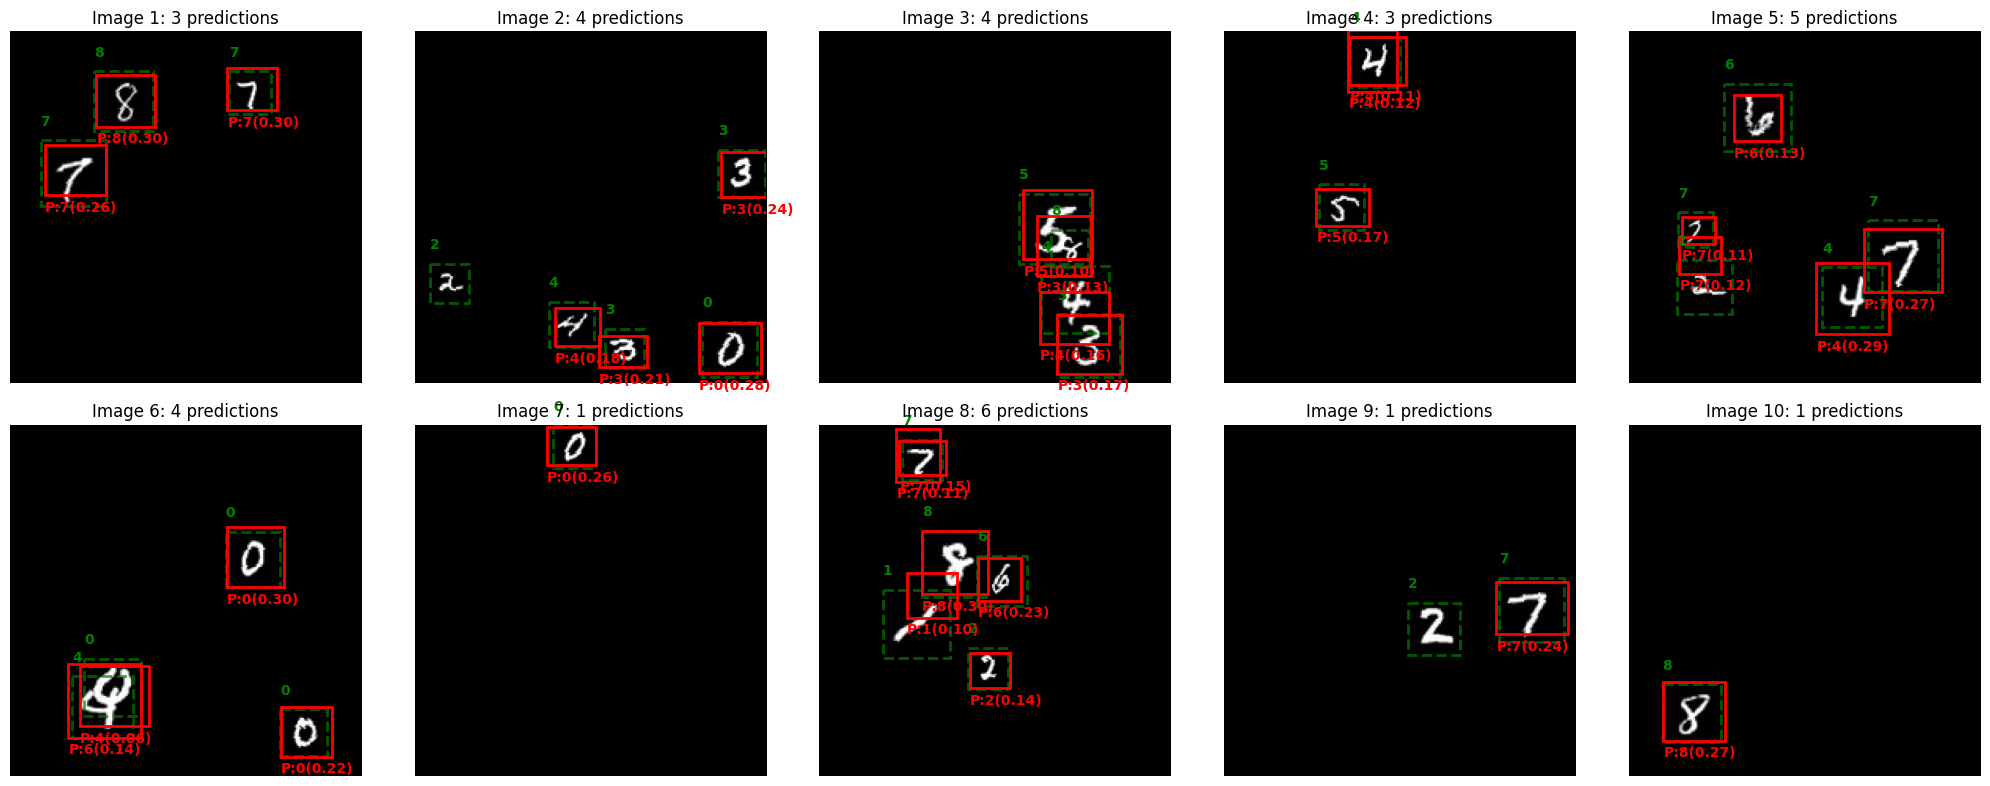

In [35]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

num_images = 10

images_list = []
target_list = []

for images, targets in test_loader:
    for i in range(min(num_images, len(images))):
        images_list.append(images[i])
        target_list.append(targets[i])
        if len(images_list) >= num_images:
            break

    if len(images_list) >= num_images:
        break

rows = 2
cols = 5

fig, axes = plt.subplots(rows, cols, figsize=(20, 8))
axes = axes.flatten()

loadedd_model = loaded_model.to('cpu')

for i in range(len(images_list)):
    image = images_list[i]
    target = target_list[i]

    img_display = image.permute(1, 2, 0).numpy()

    detections = predict_image(loaded_model, image, 0.5, 'cpu')
    axes[i].imshow(img_display)
    axes[i].set_title(f"Image {i+1}: {len(detections)} predictions")
    axes[i].axis('off')

    img_height, img_width = img_display.shape[:2]

    # Draw ground truth boxes (dashed)
    if len(target['boxes']) > 0:
        for box, label in zip(target['boxes'], target['labels']):
            x_center, y_center, width, height = box

            x_center_px = x_center * img_width
            y_center_px = y_center * img_height
            width_px = width * img_width
            height_px = height * img_height

            x = x_center_px - width_px / 2
            y = y_center_px - height_px /2

            rect = patches.Rectangle((x, y), width_px, height_px,
                                     linewidth=2, edgecolor='green',
                                     facecolor='none', linestyle="--", alpha=0.7)
            axes[i].add_patch(rect)

            axes[i].text(x, y-10, f'{label.item()}',
                         color='green', fontweight='bold', fontsize=10)
            
    for j, detection in enumerate(detections):
        x_center, y_center, width, height, confidence, class_id = detection

        x_center_px = x_center * img_width
        y_center_px = y_center * img_height
        width_px = width * img_width
        height_px = height * img_height

        x = x_center_px - width_px / 2
        y = y_center_px - height_px / 2

        rect = patches.Rectangle((x, y), width_px, height_px,
                                 linewidth=2, edgecolor='red',
                                 facecolor='none', linestyle='-')
        axes[i].add_patch(rect)
        axes[i].text(x, y+height_px+ 10, f'P:{class_id}({confidence:.2f})',
                     color='red', fontweight='bold', fontsize=10)
        
    
plt.tight_layout()
plt.show()

In [37]:
# Save the trained model
torch.save(loaded_model.state_dict(), './saved_models/fully_trained_detector.pth')